(960, 1280)
(960, 1280)
0 0.10361873358488083
1 0.08740352094173431
2 0.3991435766220093
3 0.4428004026412964
4 0.25828492641448975
5 0.2676249146461487
6 0.3786781132221222
7 0.5002723932266235
best match:  1 (877, 405) (1045, 525)


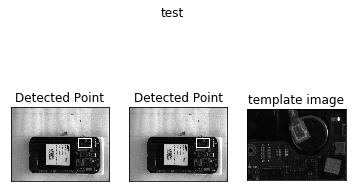

In [71]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('/home/kai/work/data/180116ConnectC/img11.jpg', cv2.IMREAD_GRAYSCALE)
print(img.shape)
# img_cropped = img[320:550, 800:1150]
img_cropped = img
print(img.shape)


bestVal = 100000

for index in range(0,8):
    filename = "/home/kai/work/data/180116ConnectC/c{}.png".format(index)
    cTemplate = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    w, h = cTemplate.shape[::-1]
    
    result = cv2.matchTemplate(img_cropped, cTemplate, cv2.TM_SQDIFF_NORMED)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)
    print(index, minVal)
    
    if minVal < bestVal:
        bestVal = minVal
        bestLoc = minLoc
        bestIndex = index
        bestResult = result

top_left = bestLoc
bottom_right = (top_left[0] + w, top_left[1] + h)
print("best match: ", bestIndex, top_left, bottom_right)
filename = "/home/kai/work/data/180116ConnectC/c{}.png".format(bestIndex)
cTemplate = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

cv2.rectangle(img_cropped,top_left, bottom_right, 255, 10)

plt.subplot(131),plt.imshow(img_cropped,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

top_left = (top_left[0] + 800, top_left[1] + 320)
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 10)
plt.subplot(132),plt.imshow(img,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow(cTemplate,cmap = 'gray')
plt.title('template image'), plt.xticks([]), plt.yticks([])


plt.suptitle("test")
plt.show()